# ПРАКТИКА ML-7. Оптимизация гиперпараметров модели

## Описание задачи

Необходимо предсказать биологический ответ молекул (столбец 'Activity') по их химическому составу (столбцы D1-D1776).

Данные представлены в формате CSV.  Каждая строка представляет молекулу.

Первый столбец Activity содержит экспериментальные данные, описывающие фактический биологический ответ [0, 1];
Остальные столбцы D1-D1776 представляют собой молекулярные дескрипторы — это вычисляемые свойства, которые могут фиксировать некоторые характеристики молекулы, например размер, форму или состав элементов.

Необходимо обучить две модели: логистическую регрессию и случайный лес. Далее нужно сделать подбор гиперпараметров с помощью базовых и продвинутых методов оптимизации. Важно использовать все четыре метода (GridSeachCV, RandomizedSearchCV, Hyperopt, Optuna) хотя бы по разу, максимальное количество итераций не должно превышать 50.

In [171]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
import hyperopt
from hyperopt import hp, fmin, tpe, Trials
import optuna

warnings.filterwarnings("ignore")
optuna.logging.set_verbosity(optuna.logging.CRITICAL)

#plt.style.use('seaborn')

random_state = 42

CPU = -1

### Загрузка и исследование данных

In [135]:
data = pd.read_csv('C:\скил\DST-156\IDE_NEW\ML-7. Оптимизация гиперпараметров модели/_train_sem09__1_.zip')
data.head()

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


In [136]:
# Проверяем наличие пропусков

data.isnull().sum().value_counts()

0    1777
Name: count, dtype: int64

In [137]:
# типы данных

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3751 entries, 0 to 3750
Columns: 1777 entries, Activity to D1776
dtypes: float64(942), int64(835)
memory usage: 50.9 MB


In [138]:
# сбалансированность классов
data['Activity'].value_counts(True)

Activity
1    0.542255
0    0.457745
Name: proportion, dtype: float64

<Axes: xlabel='Activity', ylabel='count'>

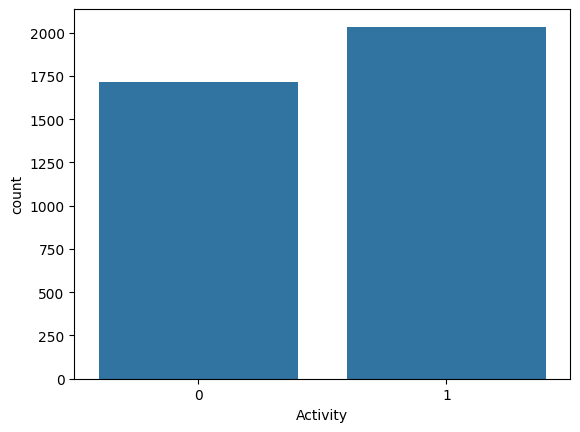

In [139]:
sns.countplot(data=data, x='Activity') # визуализируем сбалансированность классов

Дисбаланс классов небольшой. Но стратификацию всё равно лучше оставить.

In [140]:
# матрица наблюдений - X
# вектор ответов - y

X = data.drop(['Activity'], axis=1)
y = data['Activity']

In [141]:
# Разделяем выборку на тренировочную и тестовую в соотношении 80/20.
# Для сохранения соотношений целевого признака используем параметр stratify (стратифицированное разбиение).

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=random_state, test_size=0.2)

## 1. LogisticRegression 

Получим метрики, без дополнительной настройки, со значениями гиперпараметров, установленных по умолчанию, кроме парамета max_iter, т.к. задано по условию: "максимальное количество итераций не должно превышать 50".

In [142]:
# объект класса LogisticRegression
lg = linear_model.LogisticRegression(random_state=random_state, max_iter=50)

# обучаем модель, минимизируя logloss
lg.fit(X_train, y_train)
y_test_pred_lr = lg.predict(X_test)
# выводим значения метрики на тестовой выборке
print(f'f1_score на тестовом наборе модели LogisticRegression с параметрами по умолчанию : {metrics.f1_score(y_test, y_test_pred_lr) :.3f}')

f1_score на тестовом наборе модели LogisticRegression с параметрами по умолчанию : 0.777


### Оптимизация гиперпараметров модели

#### 1.1. GridSearchCV

In [143]:
# сетка гиперпараметров в виде списка словарей
param_grid_lr = [
    {
        'penalty': ['l2', 'none'],  # тип регуляризации
        'solver': ['lbfgs', 'sag'],  # алгоритм оптимизации
        'C': list(np.linspace(0.01, 1, 10, dtype=float))  # уровень силы регурялизации
    },
    {
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga'],
        'C': list(np.linspace(0.01, 1, 10, dtype=float))
    }
]

# объект класса GridSearch
grid_search_lr = GridSearchCV(
        estimator=linear_model.LogisticRegression(
        random_state=random_state,
        max_iter=50  # количество итераций на сходимость
    ),
    param_grid=param_grid_lr,
    cv=5,  #количество фолдов кросс-валидации
    n_jobs=CPU
)

%time grid_search_lr.fit(X_train, y_train)

y_test_pred_lr_gs = grid_search_lr.predict(X_test)
print(f'f1_score на тестовом наборе модели LogisticRegression (оптимизация параметров GridSearchCV): {metrics.f1_score(y_test, y_test_pred_lr_gs) :.3f}')
print(f'Наилучшие значения гиперпараметров: {grid_search_lr.best_params_}')

CPU times: total: 4.12 s
Wall time: 1min 46s
f1_score на тестовом наборе модели LogisticRegression (оптимизация параметров GridSearchCV): 0.783
Наилучшие значения гиперпараметров: {'C': 0.34, 'penalty': 'l1', 'solver': 'saga'}


Метрику удалось улучшить незначительно по сравнению с параметрами, заданными по-умолчанию

#### 1.2. RandomizedSearchCV

In [144]:
# сетка гиперпараметров в виде списка словарей
param_distributions_lr_rs = [
    {
        'penalty': ['l2', 'none'],  # тип регуляризации
        'solver': ['lbfgs', 'sag'],  # алгоритм оптимизации
        'C': list(np.linspace(0.01, 1, 10, dtype=float))  # уровень силы регурялизации
    },
    {
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga'],
        'C': list(np.linspace(0.01, 1, 10, dtype=float))
    }
]

# объект класса RandomizedSearch
random_search_lr_rs = RandomizedSearchCV(
    estimator=linear_model.LogisticRegression(random_state=random_state, max_iter=50),
    param_distributions=param_distributions_lr_rs,
    cv=5,  # количество фолдов кросс-валидации
    n_iter=20,  # количество итераций
    n_jobs=CPU
)

%time random_search_lr_rs.fit(X_train, y_train)

y_test_pred_lr_rs = random_search_lr_rs.predict(X_test)
print(f'f1_score на тестовом наборе модели LogisticRegression (оптимизация параметров RandomizedSearchCV): {metrics.f1_score(y_test, y_test_pred_lr_rs) :.3f}')
print(f'Наилучшие значения гиперпараметров: {random_search_lr_rs.best_params_}')

CPU times: total: 641 ms
Wall time: 23.9 s
f1_score на тестовом наборе оптимизация параметров RandomizedSearchCV: 0.783
Наилучшие значения гиперпараметров: {'solver': 'liblinear', 'penalty': 'l1', 'C': 0.45}


Метрика не изменилась по сравнению с GridSearch, но сработала значительно быстее. При этом методы предложили разные алгоритмы оптимизации.

#### 1.3. Hyperopt

In [145]:
def hyperopt_lr(
        params_lr,
        cv=5,
        X=X_train,
        y=y_train,
        random_state=random_state
):
    params_lr = {
        'penalty': params_lr['penalty'],
        'solver': params_lr['solver'],
        'C': params_lr['C']
    }

    model_lr = linear_model.LogisticRegression(
        **params_lr,
        random_state=random_state,
        max_iter=50
    )

    model_lr.fit(X, y)

    # применим  cross validation с количеством фолдов по-умолчанию
    score = cross_val_score(
        model_lr,
        X,
        y,
        cv=cv,
        scoring='f1',
        n_jobs=CPU
    ).mean()

    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

In [146]:
# пространство поиска гиперпараметров
space_lr = {
    'penalty': hp.choice('penalty', ['l1', 'l2']),
    'solver': hp.choice('solver', ['liblinear', 'saga']),
    'C': hp.uniform('C', 0.01, 1)
}

In [147]:
%%time

trials_lr = Trials() # используется для логирования результатов

best_lr = fmin(
    hyperopt_lr,
    space=space_lr,        # пространство гиперпараметров
    algo=tpe.suggest,   # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
    max_evals=20,       # максимальное количество итераций
    trials=trials_lr,      # логирование результатов
    rstate=np.random.default_rng(random_state)
)

print(f'Наилучшие значения гиперпараметров {best_lr}')

100%|██████████| 20/20 [01:20<00:00,  4.02s/trial, best loss: -0.7904516202991784]
Наилучшие значения гиперпараметров {'C': 0.2200949458234019, 'penalty': 0, 'solver': 1}
CPU times: total: 23.5 s
Wall time: 1min 20s


In [148]:
# точность для тестовой выборки
model_lr_ho = linear_model.LogisticRegression(
    random_state=random_state,
    penalty='l1',
    solver='saga',
    C=best_lr['C'],
    max_iter=50
)

model_lr_ho.fit(X_train, y_train)
y_test_pred_lr_ho = model_lr_ho.predict(X_test)
print(f'f1_score на тестовом наборе модели LogisticRegression (оптимизация параметров Hyperopt): {metrics.f1_score(y_test, y_test_pred_lr_ho) :.3f}')

f1_score на тестовом наборе оптимизация параметров Hyperopt: 0.784


Метрика увеличилась по сравнению с предыдущими значениями

#### 1.4. Optuna

In [149]:
def optuna_lr(trial_lr_op):
    # пространство поиска гиперпараметров
    penalty = trial_lr_op.suggest_categorical('penalty', ['l1', 'l2'])
    solver = trial_lr_op.suggest_categorical('solver', ['liblinear', 'saga'])
    C = trial_lr_op.suggest_float('C', 0.01, 1)

    model_lr_op = linear_model.LogisticRegression(
        penalty=penalty,
        solver=solver,
        C=C,
        max_iter=50,
        random_state=random_state
    )

    model_lr_op.fit(X_train, y_train)

    # применим cross validation с тем же количеством фолдов
    score = cross_val_score(
        model_lr_op,
        X,
        y,
        cv=5,
        scoring='f1',
        n_jobs=CPU
    ).mean()

    return score

In [150]:
%%time
# объект исследования
study_lr_op = optuna.create_study(
    study_name='LogisticRegression',
    direction='maximize'
)

# ищем лучшую комбинацию гиперпараметров n_trials раз
study_lr_op.optimize(optuna_lr, n_trials=20)

# результаты на обучающей выборке
print(f'Наилучшие значения гиперпараметров {study_lr_op.best_params}')
print(f'f1_score на обучающем наборе: {study_lr_op.best_value :.3f}')

Наилучшие значения гиперпараметров {'penalty': 'l1', 'solver': 'saga', 'C': 0.24578180913552886}
f1_score на обучающем наборе: 0.789
CPU times: total: 23.6 s
Wall time: 1min 55s


In [151]:
# рассчитаем точность для тестовой выборки
model_lr_op = linear_model.LogisticRegression(**study_lr_op.best_params, max_iter=50, random_state=random_state)
model_lr_op.fit(X_train, y_train)
y_test_pred_lr_op = model_lr_op.predict(X_test)
print(f'f1_score на тестовом наборе модели LogisticRegression (оптимизация параметров Optuna) : {metrics.f1_score(y_test, y_test_pred_lr_op) :.3f}')

f1_score на тестовом наборе LogisticRegression оптимизация параметров Optuna: 0.785


In [152]:
optuna.visualization.plot_param_importances(study_lr_op, target_name="f1_score")

Еще немного увеличили метрику. Итак лучшая метрика f1_score при использовании модели LogisticRegression получена при оптимизации гиперпараметров Optuna и составляет 0,785

## 2.RandomForest

In [215]:
# объект класса случайный лес
rf = ensemble.RandomForestClassifier(random_state=random_state)

rf.fit(X_train, y_train)

y_train_pred_rf = rf.predict(X_train)
y_test_pred_rf = rf.predict(X_test)
print(f'f1_score на тестовом наборе RandomForest с параметрами по умолчанию: {metrics.f1_score(y_test, y_test_pred_rf) :.3f}')

f1_score на тестовом наборе RandomForest с параметрами по умолчанию: 0.805


Случайный лес сразу выдает результаты, лучше, чем у логистической регресии

### Оптимизация гиперпараметров модели

#### 2.1. GridSearchCV

In [217]:
param_grid_rf = [
              {'n_estimators': list(np.linspace(100, 500, 5, dtype=int)),
                'criterion': ['gini', 'entropy'],
               'max_depth': list(np.linspace(5, 30, 6, dtype=int)),
               'min_samples_leaf': list(np.linspace(2, 30, 1, dtype=int))}
             ]

grid_search_rf = GridSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=random_state),
    param_grid=param_grid_rf,
    cv=5,
    n_jobs=CPU
)

%time grid_search_rf.fit(X_train, y_train)

y_test_pred_rf_gs = grid_search_rf.predict(X_test)
print(f'f1_score на тестовом наборе модели RandomForest (оптимизация параметров GridSearchCV): {metrics.f1_score(y_test, y_test_pred_rf_gs) :.3f}')
print(f'Наилучшие значения гиперпараметров: {grid_search_rf.best_params_}')

CPU times: total: 6.12 s
Wall time: 3min 58s
f1_score на тестовом наборе модели RandomForest (оптимизация параметров GridSearchCV): 0.803
Наилучшие значения гиперпараметров: {'criterion': 'entropy', 'max_depth': 15, 'min_samples_leaf': 2, 'n_estimators': 300}


наблюдаем назначительно ухудшение метрики по сравнению с гиперпараметрами по умолчанию

#### 2.2. RandomizedSearchCV

In [201]:
param_distributions_rf_rs = {'n_estimators': list(np.linspace(100, 500, 5, dtype=int)),
                'criterion': ['gini', 'entropy'],
               'max_depth': list(np.linspace(5, 30, 6, dtype=int)),
               'min_samples_leaf': list(np.linspace(2, 30, 1, dtype=int))}

random_search_rf_rs = RandomizedSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=random_state),
    param_distributions=param_distributions_rf_rs,
    cv=5,
    n_iter=30,
    n_jobs=CPU
)

%time random_search_rf_rs.fit(X_train, y_train)

y_test_pred_rf_rs = random_search_rf_rs.predict(X_test)
print(f'f1_score на тестовом наборе модели RandomForest (оптимизация параметров RandomizedSearchCV): {metrics.f1_score(y_test, y_test_pred_rf_rs) :.3f}')
print(f'Наилучшие значения гиперпараметров: {random_search_rf_rs.best_params_}')

CPU times: total: 4.94 s
Wall time: 1min 55s
f1_score на тестовом наборе RandomForest оптимизация параметров RandomizedSearchCV: 0.803
Наилучшие значения гиперпараметров: {'n_estimators': 300, 'min_samples_leaf': 2, 'max_depth': 15, 'criterion': 'entropy'}


Метрика не изменилась в сравнении с GridSearchCV

#### 2.3. Hyperopt

In [197]:
criterion_rf = ['gini', 'entropy']
space_rf = {'n_estimators': hyperopt.hp.quniform('n_estimators', 100, 500, 10),
            'criterion': hyperopt.hp.choice('criterion_rf', criterion_rf),
            'max_depth': hyperopt.hp.quniform('max_depth', 5, 30, 6),
            'min_samples_leaf': hyperopt.hp.quniform('min_samples_leaf', 2, 30, 1)}

In [198]:
def hyperopt_rf(
        params_rf,
        cv=5,
        X=X_train,
        y=y_train,
        random_state=random_state
):
    params_rf = {
        'n_estimators': int(params_rf['n_estimators']),
        'max_depth': int(params_rf['max_depth']),
        'min_samples_leaf': int(params_rf['min_samples_leaf'])
    }

    model_rf = ensemble.RandomForestClassifier(**params_rf, random_state=random_state)

    model_rf.fit(X, y)

    score = cross_val_score(model_rf, X, y, cv=cv, scoring="f1", n_jobs=CPU).mean()

    return -score

In [199]:
trials_rf = hyperopt.Trials()

best_params_rf = hyperopt.fmin(
    hyperopt_rf,
    space=space_rf,        # пространство гиперпараметров
    algo=hyperopt.tpe.suggest,   # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
    max_evals=30,       # максимальное количество итераций
    trials=trials_rf,      # логирование результатов
    rstate=np.random.default_rng(random_state)
)
best_rf = {'n_estimators': int(best_params_rf['n_estimators']), 
           'criterion': criterion_rf[best_params_rf['criterion_rf']], 
           'max_depth': int(best_params_rf['max_depth']), 
           'min_samples_leaf': int(best_params_rf['min_samples_leaf'])}
print(f'Наилучшие значения гиперпараметров {best_rf}')

100%|██████████| 30/30 [02:53<00:00,  5.78s/trial, best loss: -0.8162662200753499]
Наилучшие значения гиперпараметров {'n_estimators': 160, 'criterion': 'entropy', 'max_depth': 18, 'min_samples_leaf': 2}


In [200]:
model_rf_ho = ensemble.RandomForestClassifier(**best_rf, random_state=random_state)
model_rf_ho.fit(X_train, y_train)
y_test_pred_rf_ho = model_rf_ho.predict(X_test)
print(f'f1_score на тестовом наборе модели RandomForest (оптимизация параметров Hyperopt) : {metrics.f1_score(y_test, y_test_pred_rf_ho) :.3f}')

f1_score на тестовом наборе RandomForest оптимизация параметров Hyperopt: 0.807


Наблюдаем улучшение метрики по сравнению и с гиперпарамтрами по умолчанию и подбором гиперпараметров двумя предыдущими способами.

#### 2.4. Optuna

In [208]:
def optuna_rf(trial_rf_op):
    criterion = trial_rf_op.suggest_categorical('criterion', ['gini', 'entropy'])
    n_estimators = trial_rf_op.suggest_int('n_estimators', 100, 500,5)
    max_depth = trial_rf_op.suggest_int('max_depth', 5, 30,6)
    min_samples_leaf = trial_rf_op.suggest_int('min_samples_leaf', 2, 30,1)

    model_rf_op = ensemble.RandomForestClassifier(
        criterion=criterion,
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        random_state=random_state
    )
    model_rf_op.fit(X_train, y_train)

    score = cross_val_score(
        model_rf_op,
        X,
        y,
        cv=5,
        scoring='f1',
        n_jobs=CPU
    ).mean()

    return score

In [209]:
%%time
study_rf_op = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")

# ищем лучшую комбинацию гиперпараметров n_trials раз
study_rf_op.optimize(optuna_rf, n_trials=30)

print(f'Наилучшие значения гиперпараметров {study_rf_op.best_params}')
print(f'f1_score на обучающем наборе: {study_rf_op.best_value :.3f}')

Наилучшие значения гиперпараметров {'criterion': 'entropy', 'n_estimators': 425, 'max_depth': 29, 'min_samples_leaf': 2}
f1_score на обучающем наборе: 0.817
CPU times: total: 1min 7s
Wall time: 6min 28s


In [210]:
# точность для тестовой выборки
model_rf_op = ensemble.RandomForestClassifier(**study_rf_op.best_params,random_state=random_state)
model_rf_op.fit(X_train, y_train)

y_test_pred_rf_op = model_rf_op.predict(X_test)
print(f'f1_score на тестовом наборе модели RandomForest (оптимизация параметров Optuna): {metrics.f1_score(y_test, y_test_pred_rf_op) :.3f}')

f1_score на тестовом наборе RandomForest оптимизация параметров Optuna: 0.820


Значение метрики еще увеличилось. Итак, лучшая метрика при использовании RandomForest получена при оптимизации гиперпараметров Optuna и составляет 0,820